## Permute color channels 

In [139]:
#########################################
# 1. IMPORT LIBRARIES & SET GLOBAL VARS #
#########################################

import os
from os.path import exists
import glob
import re
import sys
sys.path.append('../')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import xarray as xr

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import gdown

# Threshold used for selecting reliable voxels.
NCSNR_THRESHOLD = 0.2


from PIL import Image

from sklearn.manifold import MDS
from sklearn.decomposition import PCA


import sys

import pickle

In [2]:
# Load Algonauts data

with open('../algonauts_brain_data_joint_images_8subjects.pkl', 'rb') as f:
    brainData = pickle.load(f)

shared_images = np.load('../algonauts_joint_images_8subjects.npy')
clean_images = shared_images

In [140]:
avail_models = models.list_models(module=torchvision.models)
avail_models

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'googlenet',
 'inception_v3',
 'maxvit_t',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 'regnet_x_32gf',
 'regnet_x_3_2gf',
 'regnet_x_400mf',
 'regnet_x_800mf',
 'regnet_x_8gf',
 'regnet_y_128gf',
 'regnet_y_16gf',
 'regnet_y_1_6gf',
 'regnet_y_32gf',
 'regnet_y_3_2gf',
 'regnet_y_400mf',
 'regnet_y_800mf',
 'regnet_y_8gf',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext101_64x4d',
 'resnext50_32x4d',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'sh

In [3]:
# 1000 Imagenet images, one from each category

fnames = [f for f in os.listdir('/mnt/ceph/users/sharvey/decoding/imagenet-sample-images/dataset/test/') if not f.startswith(".")]

images = []
for ind in range(len(fnames)):
    image_path = '/mnt/ceph/users/sharvey/decoding/imagenet-sample-images/dataset/test/' + fnames[ind]
    try:
        img = Image.open(image_path)
        img_array = np.array(img)
        images.append(img_array)
    except Exception as e:
        print(f"Error loading image {image_file}: {e}")

shared_images = images

In [4]:
bwimageidx = []
for i, num in enumerate([len(shared_images[i].shape) for i in range(len(shared_images))]):
    if num < 3:
        bwimageidx.append(i)
        shared_images[i] = np.repeat(shared_images[i][:, :, np.newaxis], 3, axis=2)
        

In [5]:
# generate the random permutation

num_rows = len(shared_images)
values_to_permute = np.array([0, 1, 2])
row_length = len(values_to_permute)

# Initialize a list to store the permuted rows
permutation = []

for _ in range(num_rows):
    # Generate a random permutation of [0, 1, 2] for each row
    random_row = np.random.permutation(values_to_permute)
    permutation.append(random_row)


In [9]:

# Extract representations resulting from probe inputs image_data for a list of models, and save them individually (takes a long time)

import extract_internal_reps

# internal_reps = []
# model_2nds = []
repDict = {}

model_names = ["vit_b_16"]
weights = 'first'
# image_data = test_image_data[0:1000,:,:,:]
# clean_images = shared_images
batch_size = 32
perm = 1

# permutation = np.array([1, 2, 0])

# if not np.array_equal(np.sort(permutation), np.arange(3)):
#     raise ValueError(f"Permutation array must contain all unique indices from 0 to 2.")

if perm:
    image_data = []
    for i in range(len(shared_images)):
        # permutation = np.random.permutation(3)
        single_image = shared_images[i]
        single_image_perm = single_image[...,permutation[i]]
        image_data.append(single_image_perm)
    # image_data = np.array(image_data)
else:
    image_data = shared_images

for model in model_names:  #avail_models:
    repDict[model] = extract_internal_reps.get_model_activations(model, weights, image_data, batch_size=32, saverep = True, filename = 'imagenet_sample_images_colors_permuted_indiv')
    print(model + " done")

Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main
Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cpu for inference
conv_proj
encoder
heads
Preprocessing pipeline:
ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
896
928
960
992
vit_b_16 done


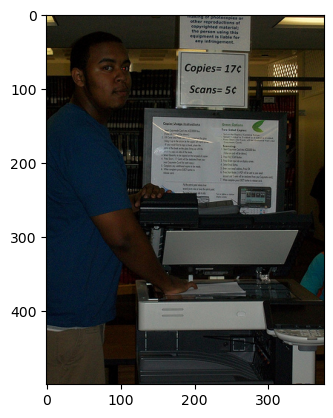

In [10]:
plt.imshow(shared_images[0])

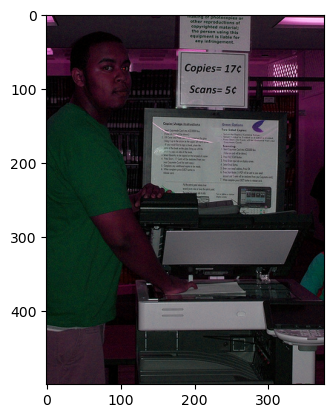

In [11]:
plt.imshow(image_data[0])

In [12]:
# Load some saved representations

repDict_cnormal = {}

model_names = ["alexnet", "vit_b_16"]

N_models = len(model_names)
for model_name in model_names:
    with open('../reps/' + model_name + '_imagenet_sample_images_colors_normal.pkl', 'rb') as f:
        new_reps = pickle.load(f)
        repDict_cnormal.update(new_reps)
        print(model_name)

# model_names, _ = zip(*repDict.items())
model_names = [value for value in repDict_cnormal.keys()]
# internal_reps = [value[0] for value in repDict.values()]


alexnet
vit_b_16


In [13]:
# Load some saved representations

repDict_cperm = {}

model_names = ["alexnet", "vit_b_16"]

N_models = len(model_names)
for model_name in model_names:
    with open('../reps/' + model_name + '_algonauts_shared_images_colors_permuted_indiv.pkl', 'rb') as f:
        new_reps = pickle.load(f)
        repDict_cperm.update(new_reps)
        print(model_name)

# model_names, _ = zip(*repDict.items())
model_names = [value for value in repDict_cperm.keys()]
# internal_reps = [value[0] for value in repDict.values()]


alexnet
vit_b_16


## Normal images

In [97]:
layer_names = []
internal_reps = []
layer_models = []

for model_name in model_names:
    layer_names.extend([value for value in repDict_cnormal[model_name].keys()])
    internal_reps.extend([value for value in repDict_cnormal[model_name].values()])
    layer_models.extend([model_name] * len([value for value in repDict_cnormal[model_name].keys()]))


In [98]:
# Make sure representations are flattened

internal_reps = [internal_reps[i].reshape((internal_reps[i].shape[0], np.prod(list(internal_reps[i].shape[1:])) )) for i in range(len(internal_reps))]

[internal_rep.shape for internal_rep in internal_reps]


[(1000, 150528),
 (1000, 193600),
 (1000, 193600),
 (1000, 46656),
 (1000, 139968),
 (1000, 139968),
 (1000, 32448),
 (1000, 64896),
 (1000, 64896),
 (1000, 43264),
 (1000, 43264),
 (1000, 43264),
 (1000, 43264),
 (1000, 9216),
 (1000, 9216),
 (1000, 9216),
 (1000, 1000),
 (1000, 150528),
 (1000, 150528),
 (1000, 151296),
 (1000, 151296),
 (1000, 151296),
 (1000, 151296),
 (1000, 151296),
 (1000, 151296),
 (1000, 151296),
 (1000, 151296),
 (1000, 151296),
 (1000, 151296),
 (1000, 151296),
 (1000, 151296),
 (1000, 151296),
 (1000, 1000)]

In [16]:
import metrics 

dd = metrics.LinearDecodingSimilarityMulti(center_columns=True, a = 0, b = 1, whiten = False, alpha = 0.5)
cached = dd.cache(internal_reps, returnGinv=False) # this part takes a long time
# cached = dd.cache(reps_pcs, returnGinv=False) # this part takes a long time
np.savez('../cached_matrices/Kx_cache_alexnet_vit_b_16_imagenet_sample_a0b1_all_layers_colors_normal.npz', cached, layer_names)




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
Done caching.


In [99]:
# load previously computed cache

loaded_cache = np.load('../cached_matrices/Kx_cache_alexnet_vit_b_16_imagenet_sample_a0b1_all_layers_colors_normal.npz')

# cached = loaded_cache
cached = loaded_cache["arr_0"]
layer_names = loaded_cache["arr_1"]
layer_names = [str(layer_name) for layer_name in layer_names]

In [100]:
layer_names

['pixels',
 'feature.0',
 'feature.1',
 'feature.2',
 'feature.3',
 'feature.4',
 'feature.5',
 'feature.6',
 'feature.7',
 'feature.8',
 'feature.9',
 'feature.10',
 'feature.11',
 'feature.12',
 'features',
 'avgpool',
 'classifier',
 'pixels',
 'conv_proj',
 'encoder_layer_0',
 'encoder_layer_1',
 'encoder_layer_2',
 'encoder_layer_3',
 'encoder_layer_4',
 'encoder_layer_5',
 'encoder_layer_6',
 'encoder_layer_7',
 'encoder_layer_8',
 'encoder_layer_9',
 'encoder_layer_10',
 'encoder_layer_11',
 'encoder',
 'heads']

### Max and min metrics (normal images)

In [111]:
ind1 = 7
ind2 = -8

# metric_type = 'similarity'
metric_type = 'distance'


KX = cached[ind1]
KY = cached[ind2]

if metric_type == 'similarity':
    A = (1/2)*(KX@KY + KY@KX)
elif metric_type == 'distance':
    A = (KX - KY)@(KX - KY)
else:
    print('check metric type')

vals, vecs = np.linalg.eig(A)

idx = vals.argsort()[::-1]   
vals = vals[idx]
vecs = vecs[:,idx]

print(layer_names[ind1])
print(layer_names[ind2])

feature.6
encoder_layer_6


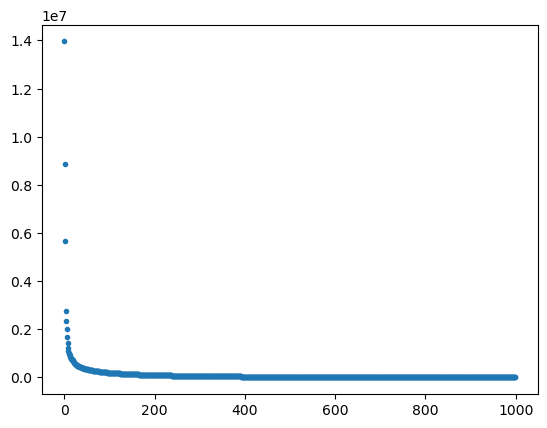

In [112]:
plt.plot(vals,'.')

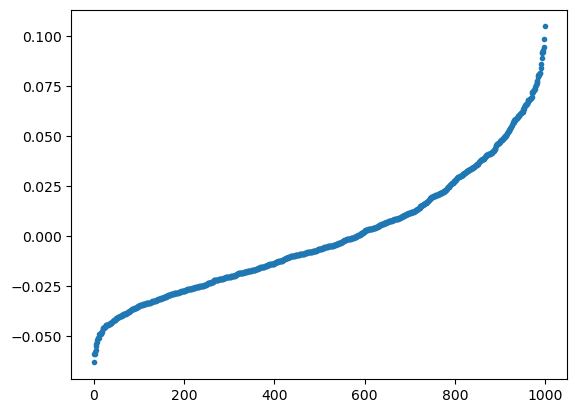

In [113]:
# Pick an eigenvector z

zind = 0
sorted_img_idx = vecs[:,zind].argsort()[::-1]
plt.plot(np.sort(vecs[:,zind]),'.')

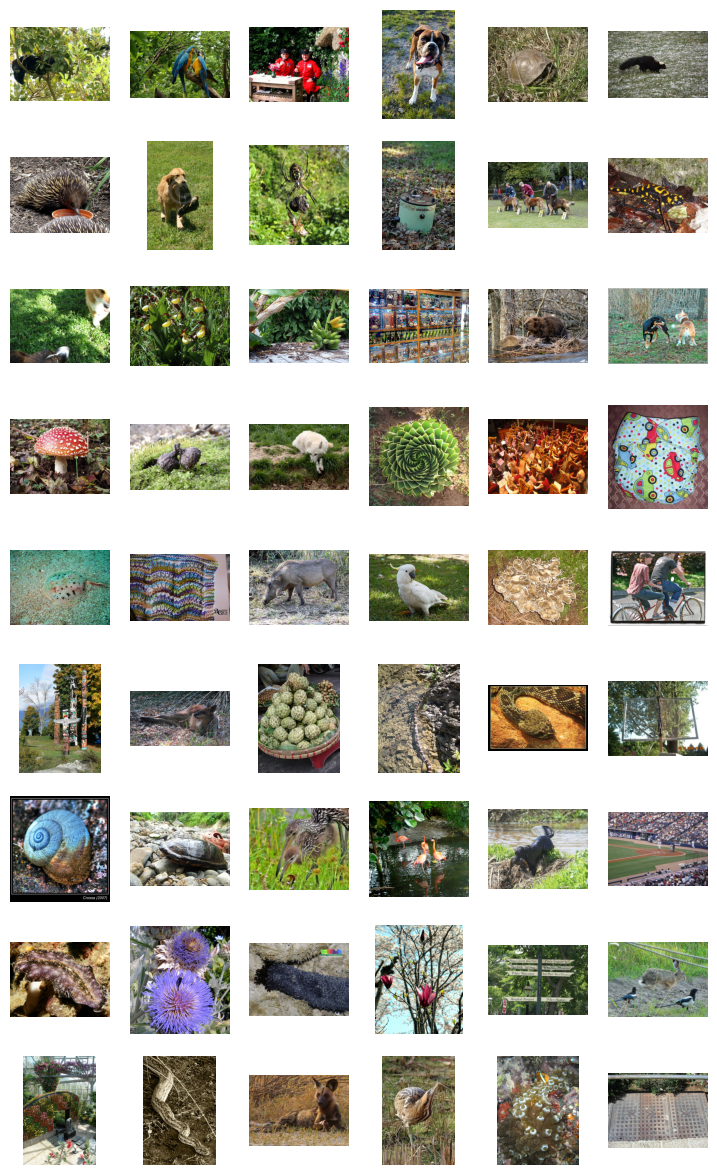

In [116]:
import matplotlib.pyplot as plt

nimgs = 54
ncols = 6
nrows = int(np.ceil(nimgs/ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(9,15))
ind = 0

for row in range(nrows):
    for column in range(ncols):
        if ind == nimgs:
            break
        else:
            # image = test_image_data[sorted_img_idx[ind],:,:,:]
            image = shared_images[sorted_img_idx[ind]]
            ax = axes[row, column]
            # ax.set_title(f"Image ({row}, {column})")
            ax.axis('off')
            ax.imshow(image)
            ind += 1

# plt.savefig('maxmin_image_tiles/distance_maxweights_' + model_names[ind1] + '_' + model_names[ind2] + '_eigvec' + str(zind) + '.pdf')

plt.show()



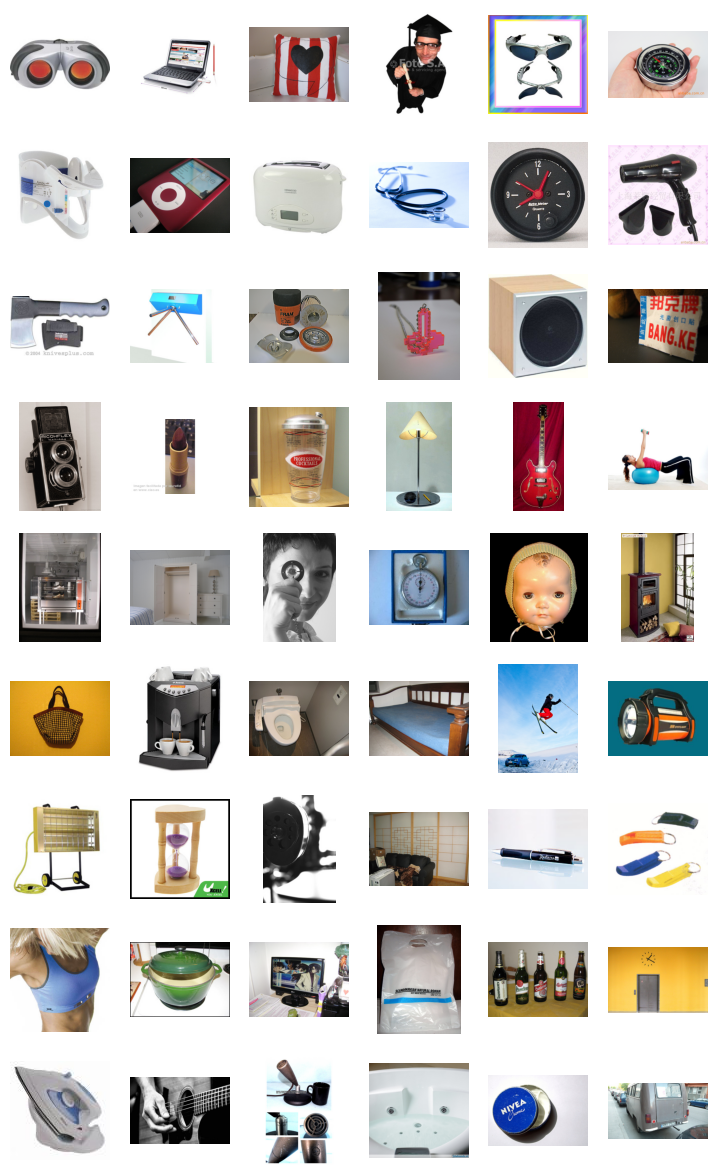

In [117]:
import matplotlib.pyplot as plt

nimgs = 54
ncols = 6
nrows = int(np.ceil(nimgs/ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(9,15))
ind = -1

for row in range(nrows):
    for column in range(ncols):
        if ind == nimgs:
            break
        else:
            # image = test_image_data[sorted_img_idx[ind],:,:,:]
            image = shared_images[sorted_img_idx[ind]]
            ax = axes[row, column]
            # ax.set_title(f"Image ({row}, {column})")
            ax.axis('off')
            ax.imshow(image)
            ind -= 1

# plt.savefig('maxmin_image_tiles/distance_minweights_' + model_names[ind1] + '_' + model_names[ind2] + '_eigvec' + str(zind) + '.pdf')

plt.show()

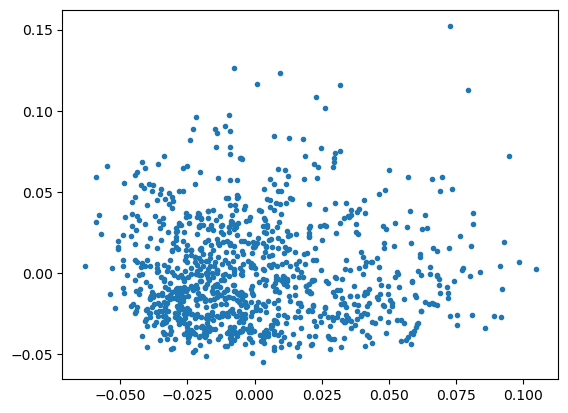

In [118]:
plt.plot(vecs[:,0],vecs[:,1],'.')

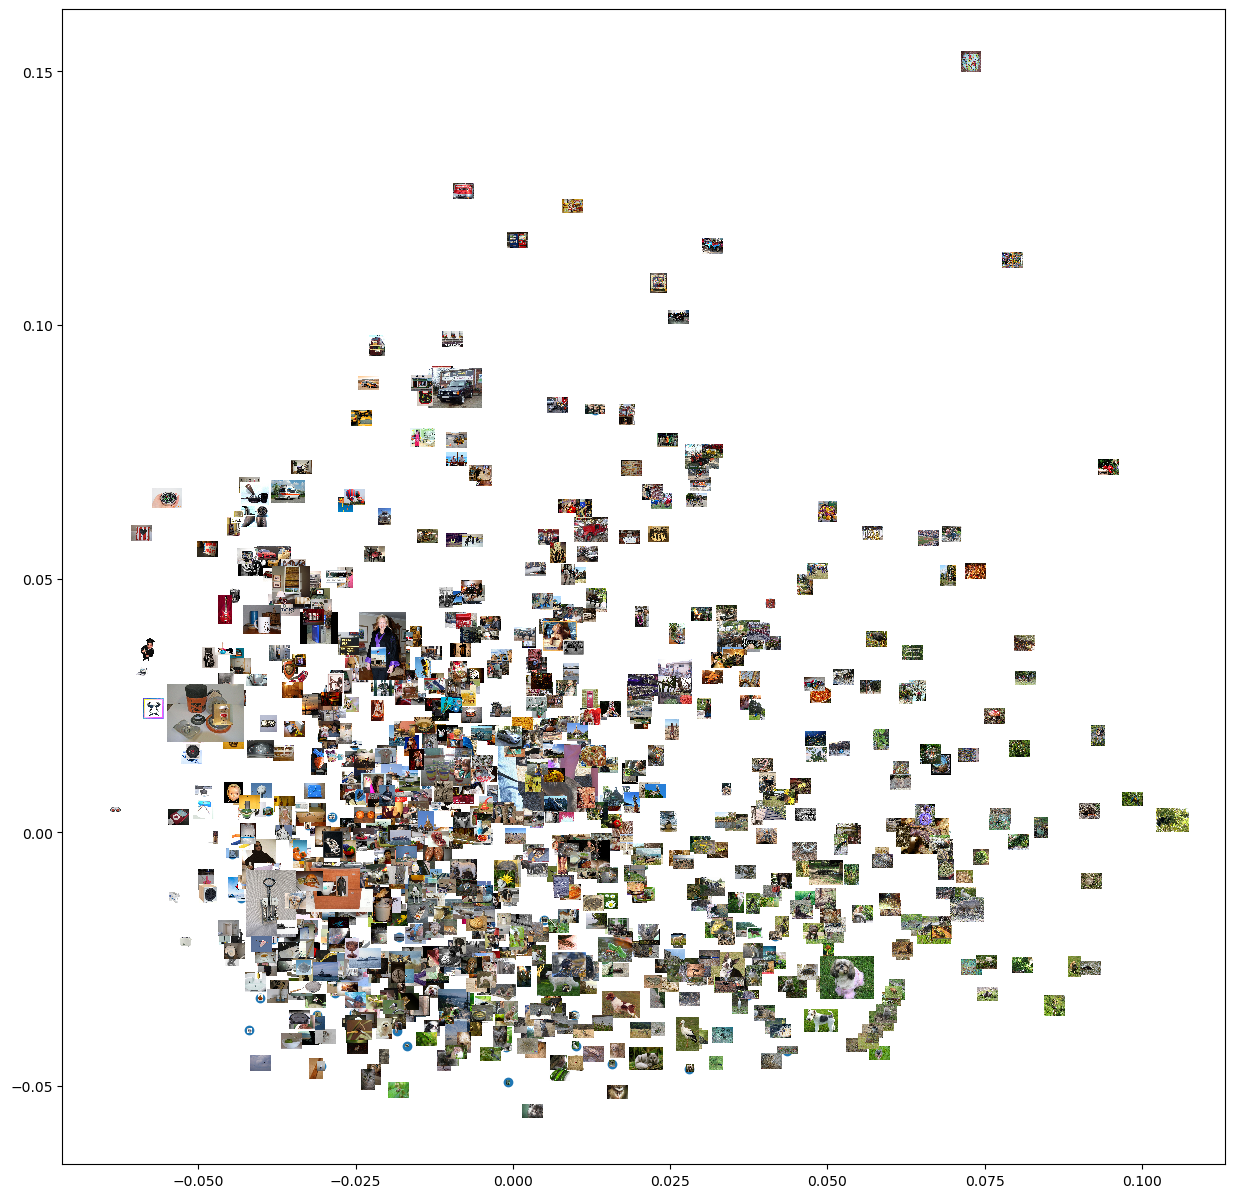

In [119]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path, zoom=1):
    return OffsetImage(plt.imread(path), zoom=zoom)



# images = [test_image_data[i,:,:,:] for i in range(1000)]
images = [shared_images[i] for i in range(len(shared_images))]


x = vecs[:,0]
y = vecs[:,1]

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(x, y) 

zoom=0.03

for x0, y0, imgdata in zip(x, y,images):
    img = OffsetImage(imgdata, zoom=zoom)
    # img = Image.fromarray(imgdata, 'RGB')
    ab = AnnotationBbox(img, (x0, y0), frameon=False)
    ax.add_artist(ab)

plt.savefig('../maxmin_image_tiles/top2eigenvecs_'+ metric_type +'_a0b1_'+ model_names[0] + '_' + layer_names[ind1] + '_' + model_names[1] + '_' + layer_names[ind2] + '_imagenet_sample_images.pdf', dpi=500)

    

## Permuted Images

In [120]:
layer_names = []
internal_reps = []
layer_models = []

for model_name in model_names:
    layer_names.extend([value for value in repDict_cperm[model_name].keys()])
    internal_reps.extend([value for value in repDict_cperm[model_name].values()])
    layer_models.extend([model_name] * len([value for value in repDict_cperm[model_name].keys()]))



In [121]:
# Make sure representations are flattened

internal_reps = [internal_reps[i].reshape((internal_reps[i].shape[0], np.prod(list(internal_reps[i].shape[1:])) )) for i in range(len(internal_reps))]

[internal_rep.shape for internal_rep in internal_reps]


[(872, 541875),
 (872, 193600),
 (872, 193600),
 (872, 46656),
 (872, 139968),
 (872, 139968),
 (872, 32448),
 (872, 64896),
 (872, 64896),
 (872, 43264),
 (872, 43264),
 (872, 43264),
 (872, 43264),
 (872, 9216),
 (872, 9216),
 (872, 9216),
 (872, 1000),
 (872, 541875),
 (872, 150528),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 1000)]

In [86]:
import metrics 

dd = metrics.LinearDecodingSimilarityMulti(center_columns=True, a = 0, b = 1, whiten = False, alpha = 0.5)
cached = dd.cache(internal_reps, returnGinv=False) # this part takes a long time
# cached = dd.cache(reps_pcs, returnGinv=False) # this part takes a long time
np.savez('../cached_matrices/Kx_cache_alexnet_vit_b_16_imagenet_sample_a0b1_all_layers_colors_permuted_indiv.npz', cached, layer_names)




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
Done caching.


In [122]:
# load previously computed cache

loaded_cache = np.load('../cached_matrices/Kx_cache_alexnet_vit_b_16_imagenet_sample_a0b1_all_layers_colors_permuted_indiv.npz')

# cached = loaded_cache
cached = loaded_cache["arr_0"]
layer_names = loaded_cache["arr_1"]
layer_names = [str(layer_name) for layer_name in layer_names]

In [131]:
# ind1 = 2
# ind2 = 11

# metric_type = 'similarity'
metric_type = 'distance'


KX = cached[ind1]
KY = cached[ind2]

if metric_type == 'similarity':
    A = (1/2)*(KX@KY + KY@KX)
elif metric_type == 'distance':
    A = (KX - KY)@(KX - KY)
else:
    print('check metric type')

vals, vecs = np.linalg.eig(A)

idx = vals.argsort()[::-1]   
vals = vals[idx]
vecs = vecs[:,idx]

print(layer_names[ind1])
print(layer_names[ind2])

feature.6
encoder_layer_6


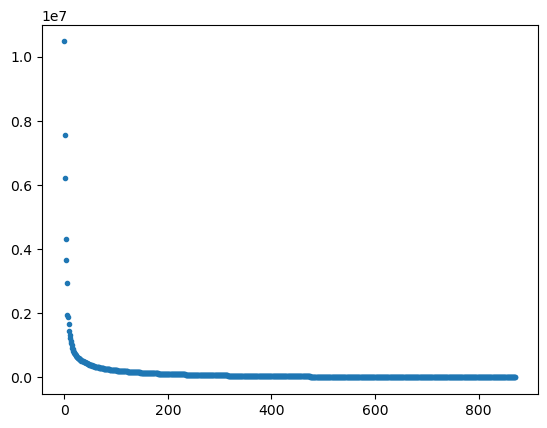

In [132]:
plt.plot(vals,'.')

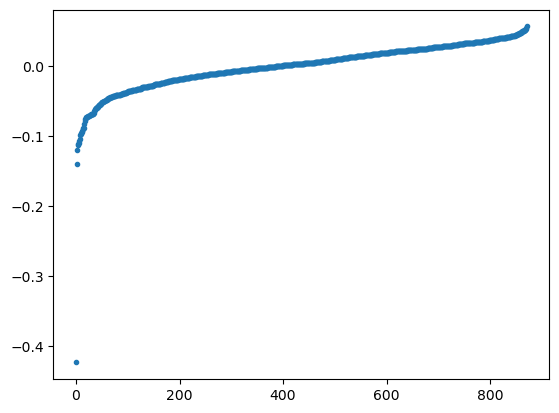

In [133]:
# Pick an eigenvector z

zind = 0
sorted_img_idx = vecs[:,zind].argsort()[::-1]
plt.plot(np.sort(vecs[:,zind]),'.')

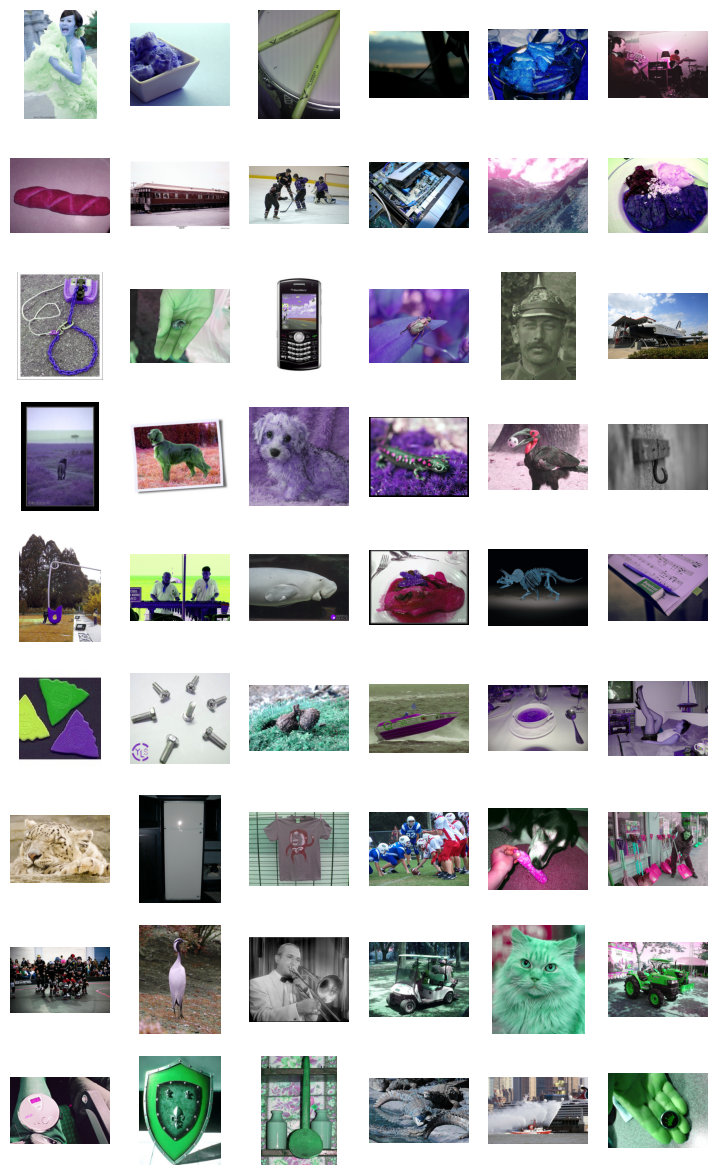

In [134]:
import matplotlib.pyplot as plt

nimgs = 54
ncols = 6
nrows = int(np.ceil(nimgs/ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(9,15))
ind = 0

for row in range(nrows):
    for column in range(ncols):
        if ind == nimgs:
            break
        else:
            # image = test_image_data[sorted_img_idx[ind],:,:,:]
            image = image_data[sorted_img_idx[ind]]
            ax = axes[row, column]
            # ax.set_title(f"Image ({row}, {column})")
            ax.axis('off')
            ax.imshow(image)
            ind += 1

# plt.savefig('maxmin_image_tiles/distance_maxweights_' + model_names[ind1] + '_' + model_names[ind2] + '_eigvec' + str(zind) + '.pdf')

plt.show()



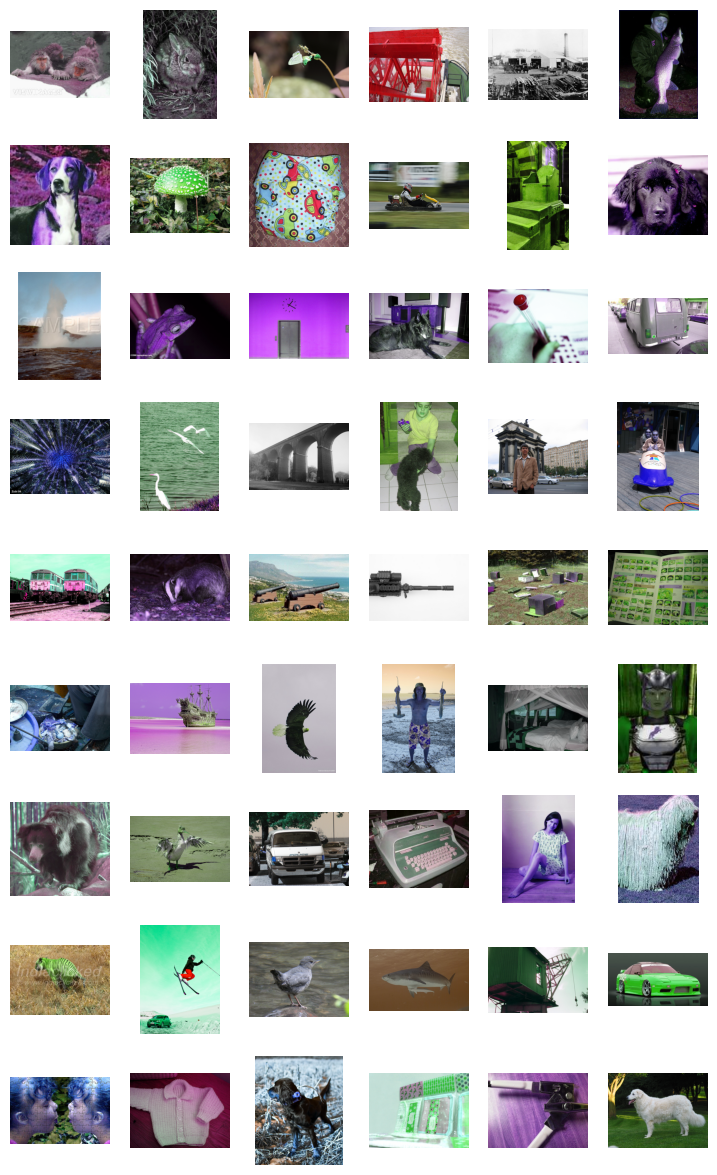

In [135]:
import matplotlib.pyplot as plt

nimgs = 54
ncols = 6
nrows = int(np.ceil(nimgs/ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(9,15))
ind = -1

for row in range(nrows):
    for column in range(ncols):
        if ind == nimgs:
            break
        else:
            # image = test_image_data[sorted_img_idx[ind],:,:,:]
            image = image_data[sorted_img_idx[ind]]
            ax = axes[row, column]
            # ax.set_title(f"Image ({row}, {column})")
            ax.axis('off')
            ax.imshow(image)
            ind -= 1

# plt.savefig('maxmin_image_tiles/distance_minweights_' + model_names[ind1] + '_' + model_names[ind2] + '_eigvec' + str(zind) + '.pdf')

plt.show()

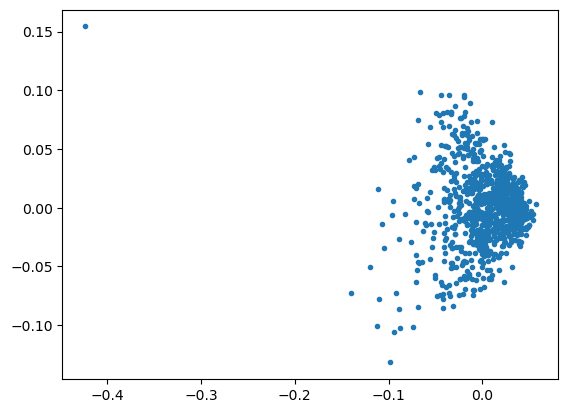

In [137]:
plt.plot(vecs[:,0],vecs[:,1],'.')

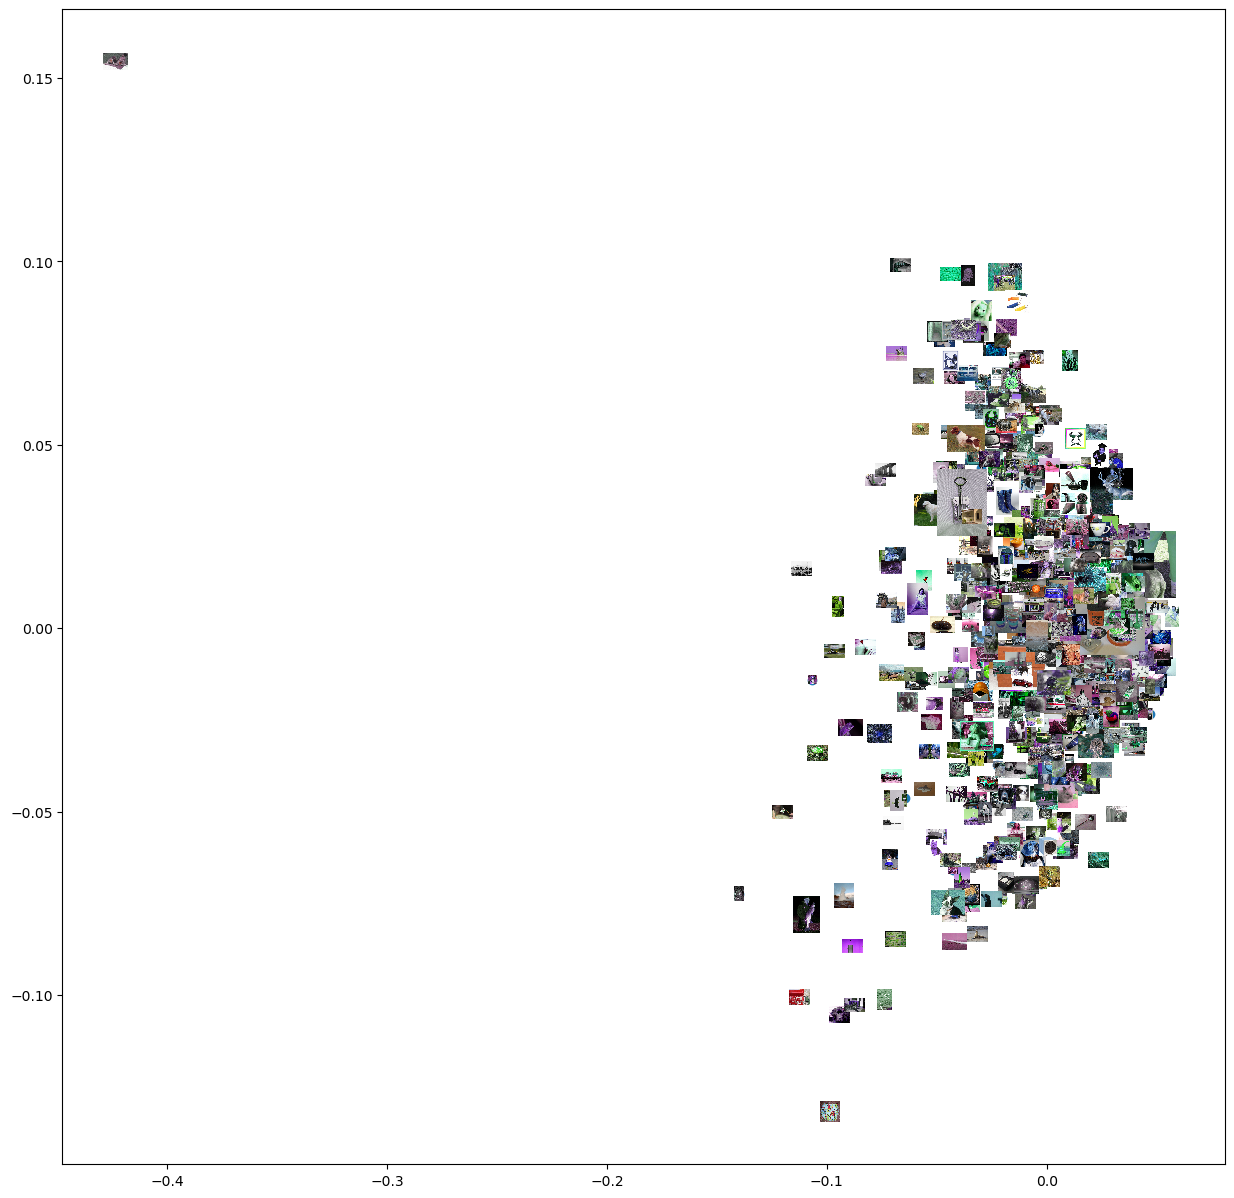

In [138]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path, zoom=1):
    return OffsetImage(plt.imread(path), zoom=zoom)



# images = [test_image_data[i,:,:,:] for i in range(1000)]
images = [image_data[i] for i in range(len(image_data))]


x = vecs[:,0]
y = vecs[:,1]

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(x, y) 

zoom=0.03

for x0, y0, imgdata in zip(x, y,images):
    img = OffsetImage(imgdata, zoom=zoom)
    # img = Image.fromarray(imgdata, 'RGB')
    ab = AnnotationBbox(img, (x0, y0), frameon=False)
    ax.add_artist(ab)

plt.savefig('../maxmin_image_tiles/top2eigenvecs_'+ metric_type +'_a0b1_'+ model_names[0] + '_' + layer_names[ind1] + '_' + model_names[1] + '_' + layer_names[ind2] + 'random_color_perms.pdf', dpi=500)

    